## Austin Coursey and Abel Diaz AML Project

### Setup

Create and activate the conda environment using:

*conda env create -f environment.yml*

*conda activate aml*

Attach the environment to Jupyter using:

*python -m ipykernel install --user --name=aml*

Open this notebook using the command

*jupyter notebook*

inside your activated *aml* environment (if this command does not work, use *pip install notebook*.) 

Go to Kernel -> change kernel -> aml at the top.

You should be able to import all of the following packages.

In [1]:
import normflows as nf
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

from laplace import Laplace, marglik_training, DiagLaplace
from laplace.curvature import BackPackGGN

from sklearn import datasets
from sklearn.metrics import mean_squared_error

C:\Users\austi\miniconda3\envs\aml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Subclass of Normalizing Flow used to perform EB

class NormalizingForward(nf.NormalizingFlow):
    def forward(self, x):
        return torch.unsqueeze(torch.unsqueeze(super().forward_kld(x), 0), 0)

### Empirical Bayes for Neural Networks

Based off paper https://arxiv.org/pdf/2104.04975.pdf by Immer et al.

We are using the laplace-torch (https://aleximmer.github.io/Laplace/#laplace.marglik_training) package to compute the Laplace approximation. This package also has a *marglik_training* method which implements their algorithm from the paper above.  

#### Importing the Pima Indians dataset as a simple regression task (https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset)

In [3]:
data = datasets.load_diabetes()
X = data['data']
X_test = X[int(X.shape[0]*0.8):]
X = X[0:X.shape[0]-X_test.shape[0]]

y = data['target']
y_test = y[int(y.shape[0]*0.8):]
y = y[0:y.shape[0]-y_test.shape[0]]

In [4]:
print(X.shape, X_test.shape, y.shape, y_test.shape)

(353, 10) (89, 10) (353,) (89,)


#### Defining a standard MLP using PyTorch

In [5]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(X.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )

  def forward(self, x):
    x = self.layers(x)
    return x

In [6]:
train_loader = DataLoader(dataset=TensorDataset(torch.tensor(X, dtype=torch.float32),torch.tensor(y.reshape(y.shape[0], 1), dtype=torch.float32)), batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test.reshape(y_test.shape[0], 1))), batch_size=1, shuffle=False)

In [7]:
def train(train_loader, mlp, loss_fn, optimizer):
    mlp.train()
    epoch_loss = 0

    for i, (X, y) in enumerate(train_loader):
        pred = mlp(X.float())
        loss = loss_fn(pred, y.float())
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
         
    print(f"loss: {epoch_loss/i:>7f}")
    return epoch_loss / i
            
def test(test_loader, mlp, loss_fn):
    mlp.eval()

    size = len(test_loader.dataset)
    num_batches = len(test_loader)

    test_preds = []
    test_loss = 0

    with torch.no_grad():
        for i, (X, y) in enumerate(test_loader):

            pred = mlp(X.float())
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches

    print(f"Avg loss: {test_loss:>8f} \n")

#### Training the standard MLP for 750 epochs

In [8]:
mlp = MLP()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [9]:
epochs = 750
mlp_losses = [0]*epochs

for t in range(epochs):
    print("Epoch", t)
    mlp_losses[t] = train(train_loader, mlp, loss_fn, optimizer)

Epoch 0
loss: 28924.325051
Epoch 1
loss: 29242.028809
Epoch 2
loss: 29188.128063
Epoch 3
loss: 30465.699574
Epoch 4
loss: 30363.073864
Epoch 5
loss: 29465.781161
Epoch 6
loss: 31225.521307
Epoch 7
loss: 28591.828325
Epoch 8
loss: 35155.833097
Epoch 9
loss: 28768.589089
Epoch 10
loss: 30765.893288
Epoch 11
loss: 33542.453303
Epoch 12
loss: 28997.743874
Epoch 13
loss: 29390.087713
Epoch 14
loss: 28139.601962
Epoch 15
loss: 27828.363703
Epoch 16
loss: 37741.835050
Epoch 17
loss: 28829.877486
Epoch 18
loss: 29003.157493
Epoch 19
loss: 33756.610263
Epoch 20
loss: 30193.163175
Epoch 21
loss: 27353.006126
Epoch 22
loss: 26837.637385
Epoch 23
loss: 28862.093217
Epoch 24
loss: 29350.889205
Epoch 25
loss: 27494.373935
Epoch 26
loss: 30096.593572
Epoch 27
loss: 25968.566806
Epoch 28
loss: 29424.097124
Epoch 29
loss: 29186.236683
Epoch 30
loss: 26287.204901
Epoch 31
loss: 25075.245872
Epoch 32
loss: 24726.278365
Epoch 33
loss: 28409.120117
Epoch 34
loss: 24280.652743
Epoch 35
loss: 23886.360485
Ep

loss: 3435.843842
Epoch 306
loss: 3438.168916
Epoch 307
loss: 4543.360374
Epoch 308
loss: 4022.293701
Epoch 309
loss: 3426.156502
Epoch 310
loss: 3416.510921
Epoch 311
loss: 3468.877586
Epoch 312
loss: 3419.923718
Epoch 313
loss: 3894.620583
Epoch 314
loss: 3406.044850
Epoch 315
loss: 3626.326660
Epoch 316
loss: 4629.774103
Epoch 317
loss: 3504.982488
Epoch 318
loss: 3970.046120
Epoch 319
loss: 3585.739236
Epoch 320
loss: 4544.685580
Epoch 321
loss: 3400.533636
Epoch 322
loss: 4213.471480
Epoch 323
loss: 3388.746464
Epoch 324
loss: 3907.759078
Epoch 325
loss: 3429.339294
Epoch 326
loss: 3382.341281
Epoch 327
loss: 3462.681469
Epoch 328
loss: 3536.810591
Epoch 329
loss: 3878.139182
Epoch 330
loss: 3375.282676
Epoch 331
loss: 3885.195956
Epoch 332
loss: 3405.768954
Epoch 333
loss: 3408.993369
Epoch 334
loss: 3582.721480
Epoch 335
loss: 3476.235085
Epoch 336
loss: 3449.446345
Epoch 337
loss: 3447.281416
Epoch 338
loss: 4270.087979
Epoch 339
loss: 3539.562900
Epoch 340
loss: 3570.830145
Ep

loss: 3222.451172
Epoch 605
loss: 4232.696589
Epoch 606
loss: 3110.879983
Epoch 607
loss: 3141.254794
Epoch 608
loss: 3264.002419
Epoch 609
loss: 3294.804332
Epoch 610
loss: 3350.621748
Epoch 611
loss: 3268.054921
Epoch 612
loss: 2994.843478
Epoch 613
loss: 3022.577706
Epoch 614
loss: 4210.605913
Epoch 615
loss: 3243.402344
Epoch 616
loss: 3015.372897
Epoch 617
loss: 3017.649991
Epoch 618
loss: 2999.177642
Epoch 619
loss: 2992.533280
Epoch 620
loss: 3217.900135
Epoch 621
loss: 3322.333185
Epoch 622
loss: 3127.870816
Epoch 623
loss: 3018.602375
Epoch 624
loss: 3024.691661
Epoch 625
loss: 3120.470881
Epoch 626
loss: 3475.409746
Epoch 627
loss: 2987.626593
Epoch 628
loss: 2984.195417
Epoch 629
loss: 3149.345126
Epoch 630
loss: 3870.488192
Epoch 631
loss: 3086.447465
Epoch 632
loss: 3150.393799
Epoch 633
loss: 3015.857891
Epoch 634
loss: 2975.858602
Epoch 635
loss: 2979.805164
Epoch 636
loss: 3028.260459
Epoch 637
loss: 2993.432060
Epoch 638
loss: 3023.964744
Epoch 639
loss: 2985.616504
Ep

In [10]:
test(test_loader, mlp, loss_fn)

Avg loss: 3074.370668 



(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.,
        40000.]),
 [Text(0, 0.0, '0'),
  Text(0, 5000.0, '5000'),
  Text(0, 10000.0, '10000'),
  Text(0, 15000.0, '15000'),
  Text(0, 20000.0, '20000'),
  Text(0, 25000.0, '25000'),
  Text(0, 30000.0, '30000'),
  Text(0, 35000.0, '35000'),
  Text(0, 40000.0, '40000')])

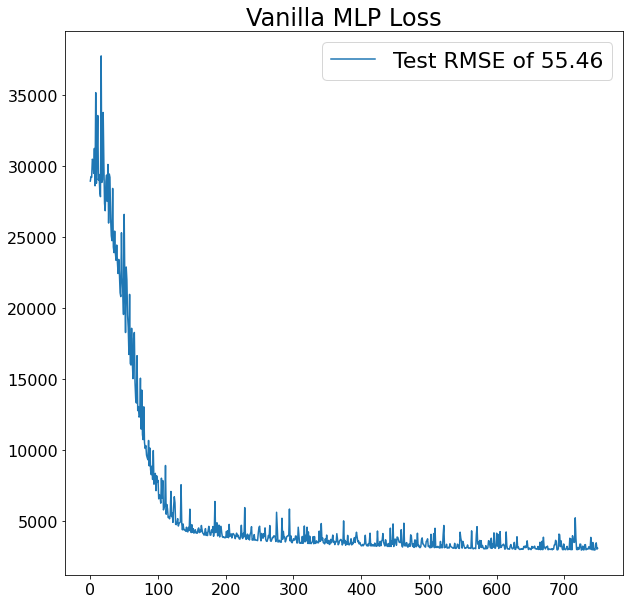

In [11]:
plt.figure(figsize=(10,10))
plt.title("Vanilla MLP Loss", fontsize="24")
plt.plot(mlp_losses, label="Test RMSE of 55.46")
plt.legend(fontsize="22")
plt.xticks(fontsize="16")
plt.yticks(fontsize="16")
# plt.savefig('./figures/mlp_loss.png')

Note that we get about 3000 MSE, which seems to be pretty standard for this problem.

#### Performing Empirical Bayes on the MLP

I am using the *marglik_training* because it should work out of the box with regression problems, but we may need to manually implement Immer's steps in other tasks.

In [12]:
eb_mlp = MLP()

# Note we are training for a the same number of epochs
la, model, margliks, eb_losses = marglik_training(
    model=eb_mlp, train_loader=train_loader, likelihood='regression',
    hessian_structure='full', backend=BackPackGGN, n_epochs=750, 
    optimizer_kwargs={'lr': 1e-2}, prior_structure='layerwise'
)

C:\Users\austi\miniconda3\envs\aml\lib\site-packages\backpack\extensions\backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.MLP'> although the module has parameters
  warnings.warn(


In [13]:
test(test_loader, model, loss_fn)

Avg loss: 2901.476322 



(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000.]),
 [Text(0, 0.0, '0'),
  Text(0, 5000.0, '5000'),
  Text(0, 10000.0, '10000'),
  Text(0, 15000.0, '15000'),
  Text(0, 20000.0, '20000'),
  Text(0, 25000.0, '25000'),
  Text(0, 30000.0, '30000')])

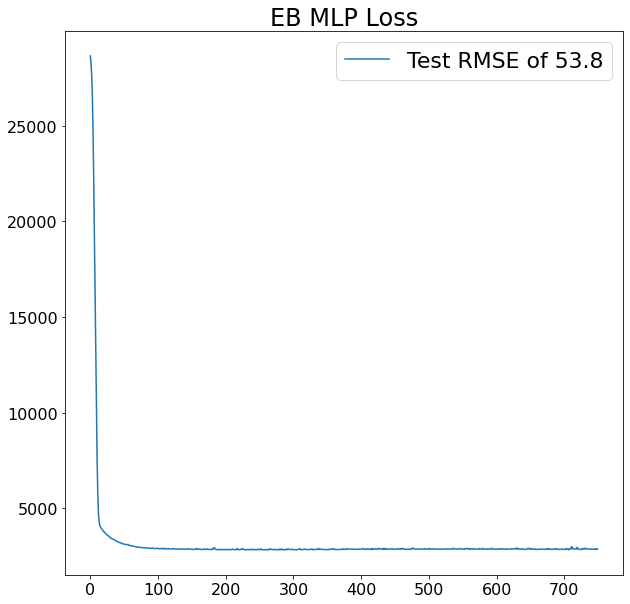

In [14]:
plt.figure(figsize=(10,10))
plt.title("EB MLP Loss", fontsize="24")
plt.plot(eb_losses, label="Test RMSE of 53.8")
plt.legend(fontsize="22")
plt.xticks(fontsize="16")
plt.yticks(fontsize="16")
# plt.savefig('./figures/eb_loss.png')

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.,
        40000.]),
 [Text(0, 0.0, '0'),
  Text(0, 5000.0, '5000'),
  Text(0, 10000.0, '10000'),
  Text(0, 15000.0, '15000'),
  Text(0, 20000.0, '20000'),
  Text(0, 25000.0, '25000'),
  Text(0, 30000.0, '30000'),
  Text(0, 35000.0, '35000'),
  Text(0, 40000.0, '40000')])

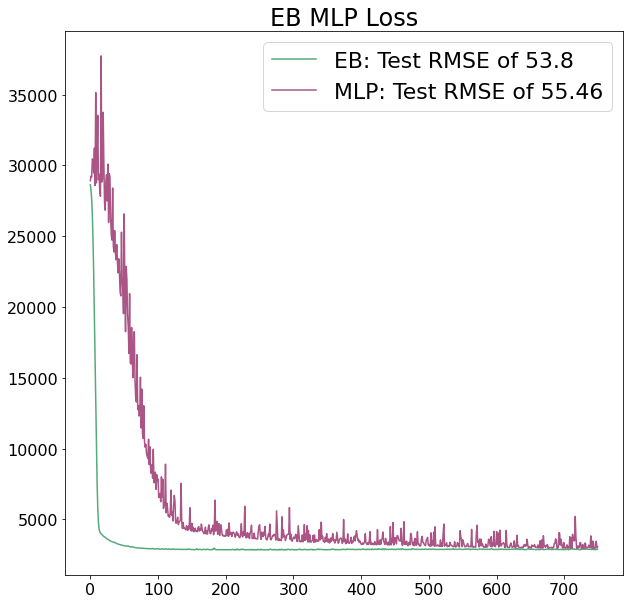

In [15]:
plt.figure(figsize=(10,10))
plt.title("EB MLP Loss", fontsize="24")
plt.plot(eb_losses, label="EB: Test RMSE of 53.8", color="#55AA79")
plt.plot(mlp_losses, label="MLP: Test RMSE of 55.46", color="#AA5586")
plt.legend(fontsize="22")
plt.xticks(fontsize="16")
plt.yticks(fontsize="16")
# plt.savefig('./figures/both_loss_eb.png')

We get much lower MSE (and in fewer epochs using EB!)

### Normalizing Flows

We are using the package *normflows* (https://github.com/VincentStimper/normalizing-flows), as they implement many different types of normalizing flow models that have a lot of customizability. 

#### 2D timeseries density estimation using Normalizing Flows

Using https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ dataset

In [16]:
# Assumes the data is in this directory
data = pd.read_csv('temperature.csv')
data = data[['TEMP', 'pm2.5']].dropna().reset_index(drop=True)
data

,TEMP,pm2.5
0,-4.0,129.0
1,-4.0,148.0
2,-5.0,159.0
3,-5.0,181.0
4,-5.0,138.0
...,...,...
41752,-2.0,8.0
41753,-3.0,10.0
41754,-3.0,10.0
41755,-4.0,8.0


In [17]:
# Normalize data
data=(data-data.min())/(data.max()-data.min())

In [18]:
x_np = np.array(data)
x_np

array([[0.24590164, 0.12977867],
       [0.24590164, 0.14889336],
       [0.2295082 , 0.15995976],
       ...,
       [0.26229508, 0.01006036],
       [0.24590164, 0.00804829],
       [0.26229508, 0.01207243]])

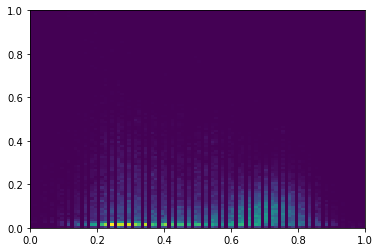

In [19]:
# Plotting data
plt.hist2d(x_np[:, 0], x_np[:, 1], bins=100)
plt.show()

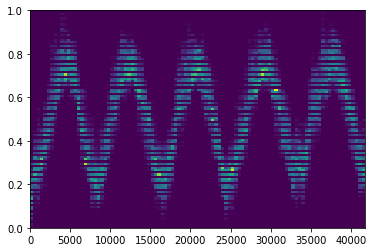

In [20]:
# Plotting x1 over time
plt.hist2d(range(x_np.shape[0]), x_np[:, 0], bins=100)
plt.show()

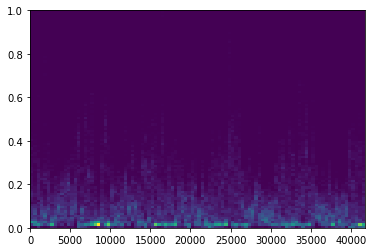

In [21]:
# Plotting x2 over time
plt.hist2d(range(x_np.shape[0]), x_np[:, 1], bins=100)
plt.show()

In [22]:
# Much of this code comes from the example at https://github.com/VincentStimper/normalizing-flows

# Set up model

# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(2)

# Define list of flows
num_layers = 16
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 64, 64, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))
    
# Construct flow model
model = NormalizingForward(base, flows)

In [23]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

C:\Users\austi\miniconda3\envs\aml\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


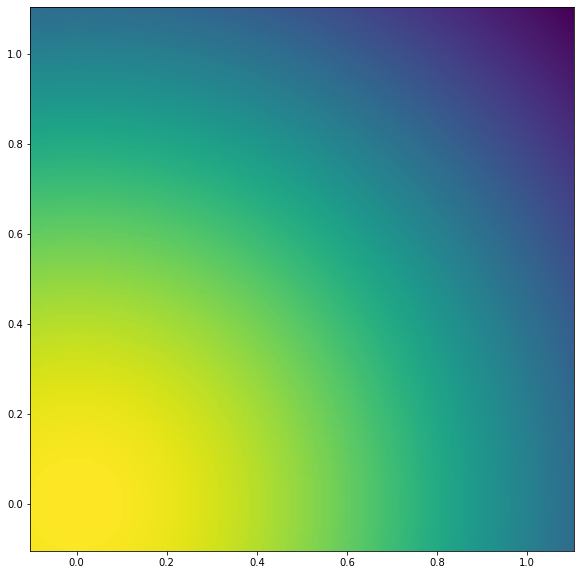

In [24]:
# Plot initial flow distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-0.1, 1.1, grid_size), torch.linspace(-0.1, 1.1, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()

 50%|███████████████████████████████████████▍                                       | 499/1000 [00:18<00:19, 26.16it/s]

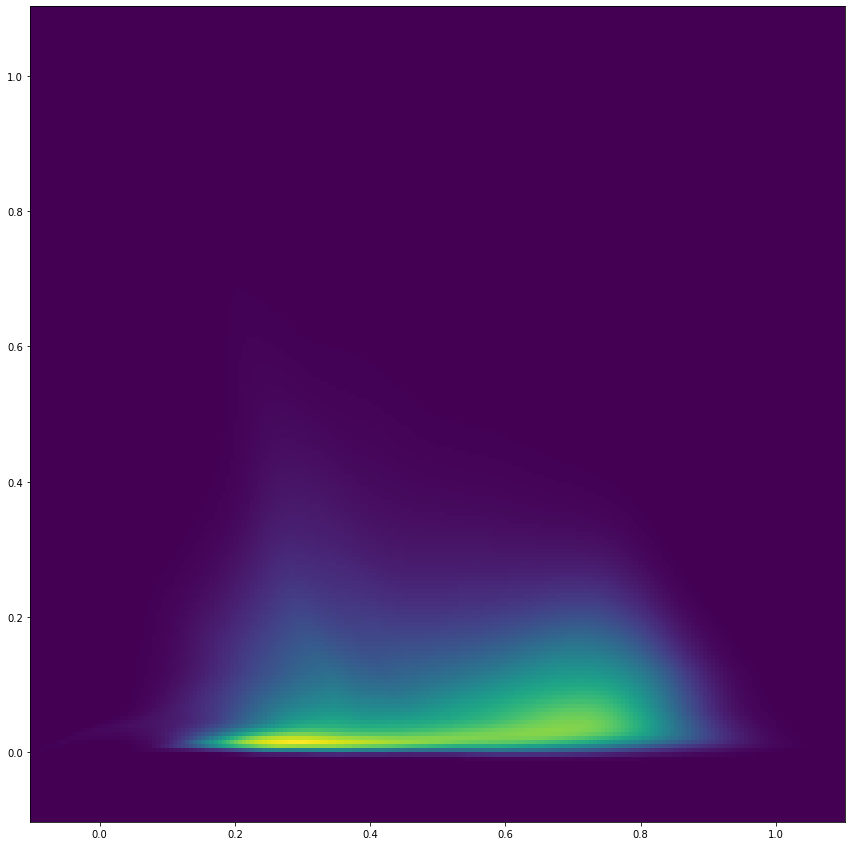

100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [00:39<00:00, 26.81it/s]

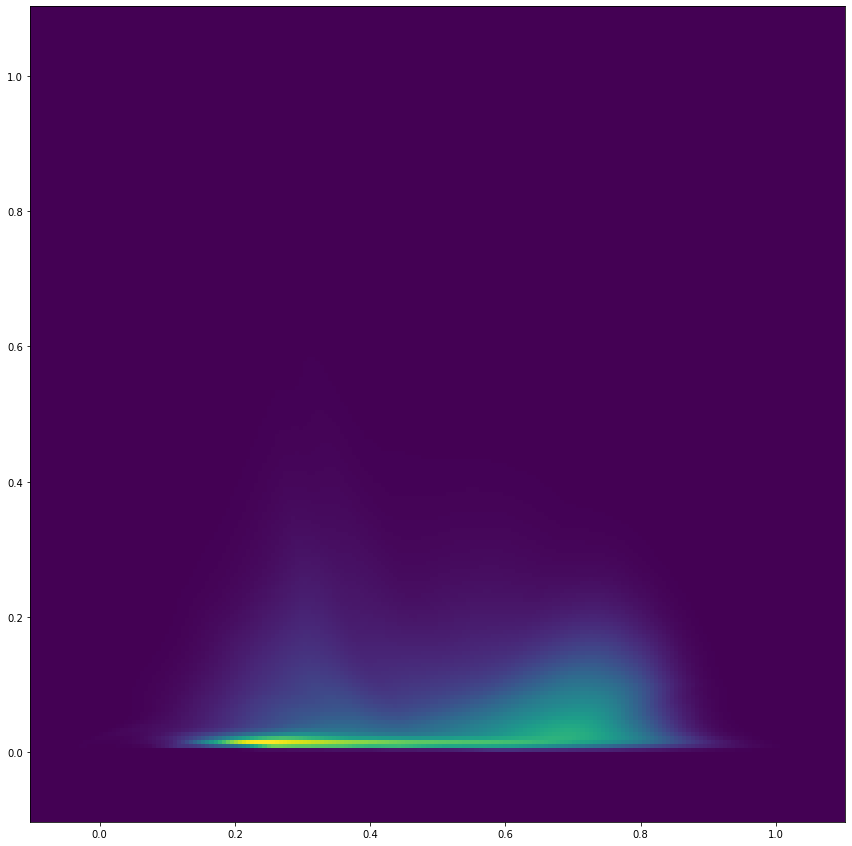

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.79it/s]


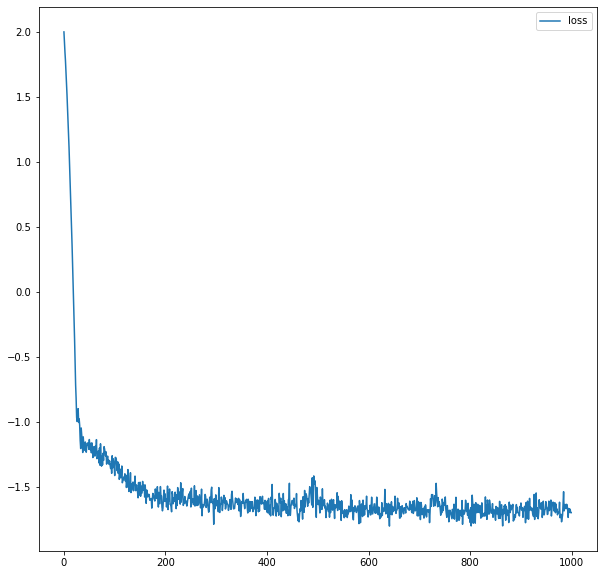

In [25]:
# Train model
max_iter = 1000
num_samples = 2 ** 9
show_iter = 500


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    # Should probably not operate on whole dataset at once - just sample from it
    sample_indices = np.random.choice(range(x_np.shape[0]), num_samples, replace=False)
    x = torch.tensor(x_np[sample_indices,:]).float().to(device)
    
    # Compute loss
    loss = model.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
        
    # Do marginal likelihood steps here too--

    # --
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned posterior
    if (it + 1) % show_iter == 0:
        model.eval()
        log_prob = model.log_prob(zz)
        model.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.gca().set_aspect('equal', 'box')
        plt.show()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [26]:
model.forward_kld(x)

tensor(-1.7291, grad_fn=<NegBackward0>)

### Combining Normalizing Flows with EB

(All of this code was pretty much a sandbox for testing different ways to try to combine these two methods - don't take it too seriously and it can be skipped since it was discarded anyway)

We can access the networks associated with each flow as follows

In [178]:
model.flows

ModuleList(
  (0): AffineCouplingBlock(
    (flows): ModuleList(
      (0): Split()
      (1): AffineCoupling(
        (param_map): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=64, bias=True)
            (1): LeakyReLU(negative_slope=0.0)
            (2): Linear(in_features=64, out_features=64, bias=True)
            (3): LeakyReLU(negative_slope=0.0)
            (4): Linear(in_features=64, out_features=2, bias=True)
          )
        )
      )
      (2): Merge()
    )
  )
  (1): Permute()
  (2): AffineCouplingBlock(
    (flows): ModuleList(
      (0): Split()
      (1): AffineCoupling(
        (param_map): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=64, bias=True)
            (1): LeakyReLU(negative_slope=0.0)
            (2): Linear(in_features=64, out_features=64, bias=True)
            (3): LeakyReLU(negative_slope=0.0)
            (4): Linear(in_features=64, out_features=2, bias=True)
          )


We can perform a chain of computations using the flows:

In [179]:
yhat1 = model.flows[0](torch.tensor(x_np).float().to(device))
yhat2 = model.flows[1](yhat1[0])
yhat3 = model.flows[2](yhat2[0])
yhat3

(tensor([[0.3567, 0.5518],
         [0.3743, 0.5401],
         [0.3667, 0.5192],
         ...,
         [0.2398, 0.5754],
         [0.2437, 0.5987],
         [0.2530, 0.6193]], grad_fn=<CatBackward0>),
 tensor([-0.3652, -0.3570, -0.3605, -0.3511, -0.3697, -0.3907, -0.3924, -0.3758,
         -0.3859, -0.3723, -0.3688, -0.3635, -0.3653, -0.3583, -0.3609, -0.3626,
         -0.3605, -0.3583, -0.3558, -0.3648, -0.3626, -0.3583, -0.3702, -0.3833,
         -0.3990, -0.4098, -0.4146, -0.4167, -0.4146, -0.4153, -0.4133, -0.4236,
         -0.4245, -0.4236, -0.4254, -0.4211, -0.4194, -0.4227, -0.4215, -0.4217,
         -0.4236, -0.4273, -0.4293, -0.4312, -0.4270, -0.4405, -0.4259, -0.4540,
         -0.4643, -0.4300, -0.4511, -0.4645, -0.4640, -0.4760, -0.4774, -0.4852,
         -0.4858, -0.4856, -0.4758, -0.4763, -0.4638, -0.4495, -0.4504, -0.4366,
         -0.4364, -0.4636, -0.4640, -0.4760, -0.4749, -0.4843, -0.4852, -0.5152,
         -0.5475, -0.5621, -0.5806, -0.5653, -0.5802, -0.5322, -0.532

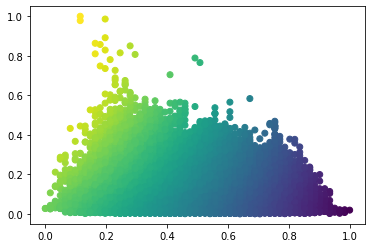

In [91]:
current_vals = [torch.tensor(x_np).float().to(device), 0]

for f in model.flows:
    current_vals = f(current_vals[0])
    
# plt.scatter(current_vals[0].data.numpy()[:,0], current_vals[0].data.numpy()[:,1], c=multivariate_normal.pdf(current_vals[0].data.numpy(), mean=np.zeros(2), cov=np.identity(2)))
# plt.scatter(x_np[:,0], x_np[:,1], c=multivariate_normal.pdf(current_vals[0].data.numpy(), mean=np.zeros(2), cov=np.identity(2)))
plt.scatter(x_np[:,0], x_np[:,1], c=model.log_prob()) # this is not enough - need to multiply by Jacobian

In [89]:
from scipy.stats import multivariate_normal
y = multivariate_normal.pdf(current_vals[0].data.numpy(), mean=np.zeros(2), cov=np.identity(2))
print(y)

[0.13816517 0.13838593 0.13876654 ... 0.13681533 0.13705194 0.13682541]


We need to get the log marginal likelihood of each network during training. Let's say we want to compute it for the first flow:

In [77]:
# We have to do the split ourselves, but we get the log marginal likelihood!

split_output = model.flows[0].flows[0](torch.tensor(x_np).float().to(device)) # Output of the Split
train_loader = DataLoader(dataset=TensorDataset(split_output[0][0],torch.tensor(np.zeros((split_output[0][0].shape[0], 2))).float().to(device)), batch_size=32, shuffle=True)
la = Laplace(model.flows[0].flows[1].param_map, 'regression')
la.fit(train_loader)

In [78]:
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
print(-1 * la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp()))

tensor(160287.0156, grad_fn=<MulBackward0>)


In [79]:
print(log_prior, log_sigma)

tensor([1.], requires_grad=True) tensor([1.], requires_grad=True)


In [80]:
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(15):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()
    
print(-1 * la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp()))

tensor(35150.0508, grad_fn=<MulBackward0>)


In [81]:
print(log_prior, log_sigma)

tensor([2.5149], requires_grad=True) tensor([-0.4999], requires_grad=True)


In [10]:
torch.tensor(x_np).float().to(device).shape

torch.Size([41757, 2])

In [49]:
train_loader = DataLoader(dataset=TensorDataset(torch.tensor(x_np).float().to(device),torch.tensor(np.zeros((x_np.shape[0], 1))).float().to(device)), batch_size=32, shuffle=True)
la = Laplace(model, 'regression')
la.fit(train_loader)

AssertionError: BackPACK extension expects a backpropagation quantity but it is None. Module: Linear(in_features=64, out_features=2, bias=True), Extension: <backpack.extensions.secondorder.hbp.KFLR object at 0x000002A8DAD4EA60>.

In [40]:
loss = model.forward(x)
loss

tensor([[-1.6597]], grad_fn=<UnsqueezeBackward0>)

In [39]:
loss.backward()
# What is the issue above??

In [14]:
with torch.no_grad():
    X, _ = next(iter(train_loader))
torch.unsqueeze(torch.unsqueeze(model(X[:1].to(device)), 0),0)

tensor([[2.0988]], grad_fn=<UnsqueezeBackward0>)

In [44]:
len(train_loader.dataset)

41757